## Импорт

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#красота - темный фон графиков для тёмной темы юпитера
from jupyterthemes import jtplot
jtplot.style('onedork')

## Разведочный анализ данных

### Общая информация, целевой признак.

In [3]:
data.sample(8)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
114,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,91,0
231,70.0,0,93,0,35,0,185000.00,1.1,134,1,1,208,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
238,65.0,1,720,1,40,0,257000.00,1.0,136,0,0,210,0
254,53.0,1,446,0,60,1,263358.03,1.0,139,1,0,215,0
224,58.0,0,582,1,25,0,504000.00,1.0,138,1,0,205,0
149,60.0,0,2261,0,35,1,228000.00,0.9,136,1,0,115,0
85,51.0,0,78,0,50,0,406000.00,0.7,140,1,0,79,0


In [4]:
data = data.rename(columns = {'DEATH_EVENT':'death_event'})

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  death_event               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Признаки в основном целочисленные, три с плавающей запятой, но к ним надо присмотреться, потому что два из них можно попробовать перевести в целочисленные.

- `age` - возраст пациента (0-120, старше и младше не бывает)
- `anaemia` - снижение показателей красных кровяных телец или гемоглобина (бинарный)
- `creatinine_phosphokinase` - уровень фермента КФК в крови (мкг/л)
- `diabetes` - наличие диабета (бинарный)
- `ejection_fraction` - процент крови, покидающей сердце при каждом сокращении (в процентах, диапазон значений от 0 до 100)
- `high_blood_pressure` - наличие гипертонии (бинарный)
- `platelets` - тромбоциты в крови (1000/мл)
- `serum_creatinine` - уровень сывороточного креатинина в крови (мг/дл)
- `serum_sodium` - уровень сывороточного натрия в крови (мэкв/л)
- `sex` - женщина или мужчина (бинарный)
- `smoking` - курит пациент или нет (бинарный)
- `time` - период наблюдения (дни) 
- `DEATH_EVENT` - целевой признак, пациент умер в течение периода наблюдения (бинарный)

Все признаки должны быть неотрицательными.
Взглянем на них.

In [6]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Да, все неотрицательные, в допустимых диапазонах (для тех значений, которые мы обозначили ранее).


In [7]:
data.duplicated().sum()

0

Дублей не наблюдается.
Построим матрицу корреляций.

<AxesSubplot:>

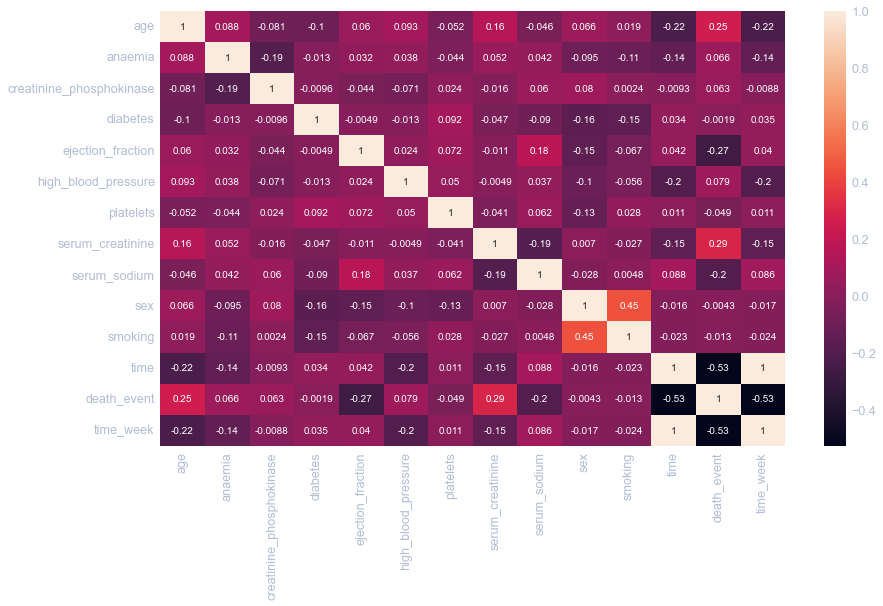

In [32]:
correlation_matrix = data.corr()

plt.figure(figsize= (16, 8))
sns.heatmap(correlation_matrix, annot = True)

Видим, что положительная корреляция есть между полом и курением, а также между временем наблюдения и целевым признаком. Также наблюдаем несколько ощутимую связь между целевым признаком и возрастом, уровнем креатинина и натрия (разнонаправленные) и размером выброса крови при сокращении сердца. 

Пропуски

In [9]:
data.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
death_event                 0
dtype: int64

Пропусков нет.

Преобразуем тип данных столбца age.

In [10]:
data['age'] = data['age'].astype(int)

Для начала посмотрим как выглядит целевой признак, то есть оценим соотношение событий. 

<AxesSubplot:xlabel='death_event', ylabel='count'>

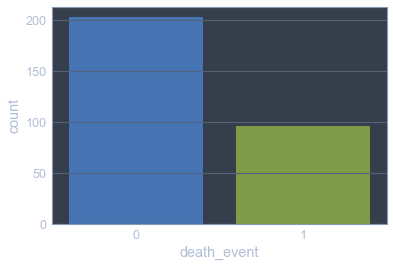

In [11]:
#sns.countplot('death_event', data=data)
sns.countplot(x=data['death_event'])

Зафиксированых случаев смерти почти в два раза меньше чем случев с положительным исходом, таким образом имеется явный дисбаланс классов. А значит и дальнейшая работа будет затруднена, например прогнозы будут более благоприятные, то есть смещаться в сторону отсутствия смерти от сердечной недостаточности.

Посмотрим как распределены сами признаки. Для удобства восприятия сначала отобразим распределение категориальных признаков, затем числовых.
К категориальным относятся: наличие анемии, диабета, высокого давления, а так же пол и факт курения.
К числовым все оставшиеся.

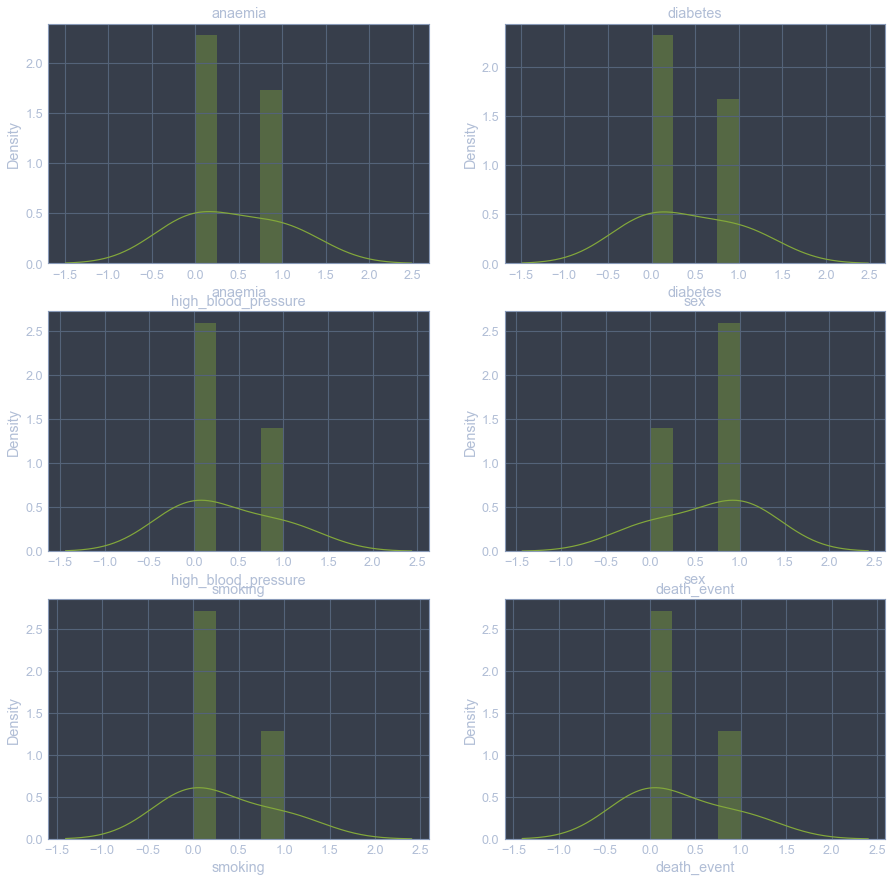

In [12]:
#категориальные признаки
list_of_categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']

fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (15,15))
for i in range(len(list_of_categorical_features)):
    plt.subplot(3,2,i+1)
    sns.distplot(data[list_of_categorical_features[i]],color = 'g', kde_kws = {'bw' : True});
    title = list_of_categorical_features[i]
    plt.title(title)

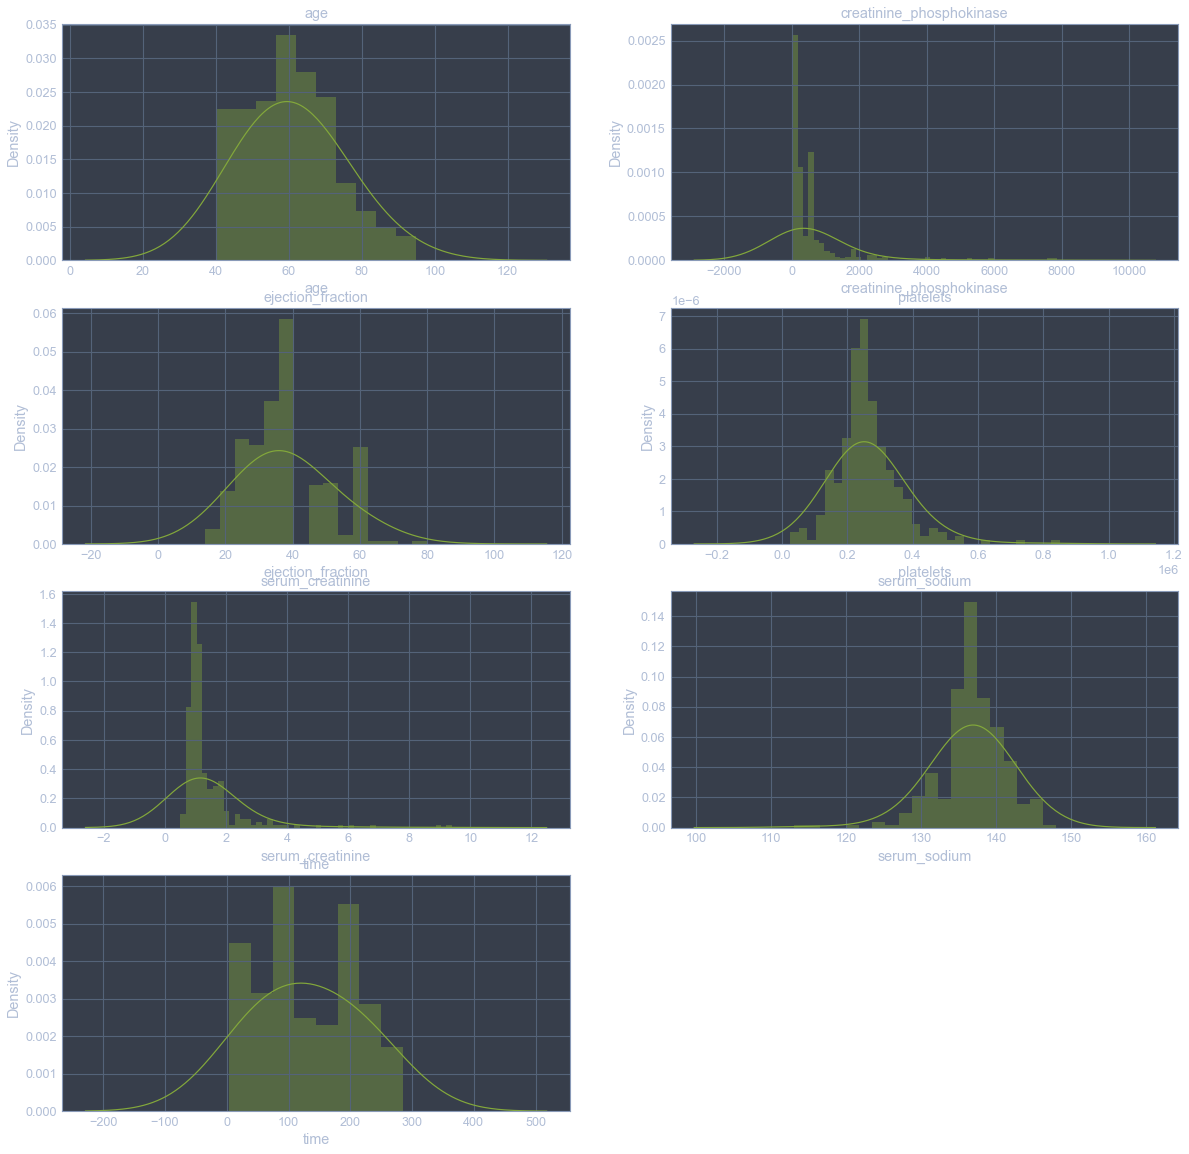

In [13]:
#числовые признаки
list_of_numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (20,20))
for i in range(len(list_of_numerical_features)):
    plt.subplot(4,2,i+1)
    sns.distplot(data[list_of_numerical_features[i]],color = 'g', kde_kws = {'bw' : True});
    title = list_of_numerical_features[i]
    plt.title(title)

Итак, почти все признаки распределены нормально, за исключением, например, времени или уровня сывороточного натрия/креатина.

Далее следует посмотреть на то как зависит, например, факт смерти от факта наличия анемии и тд... Для числовых признаков аналогично

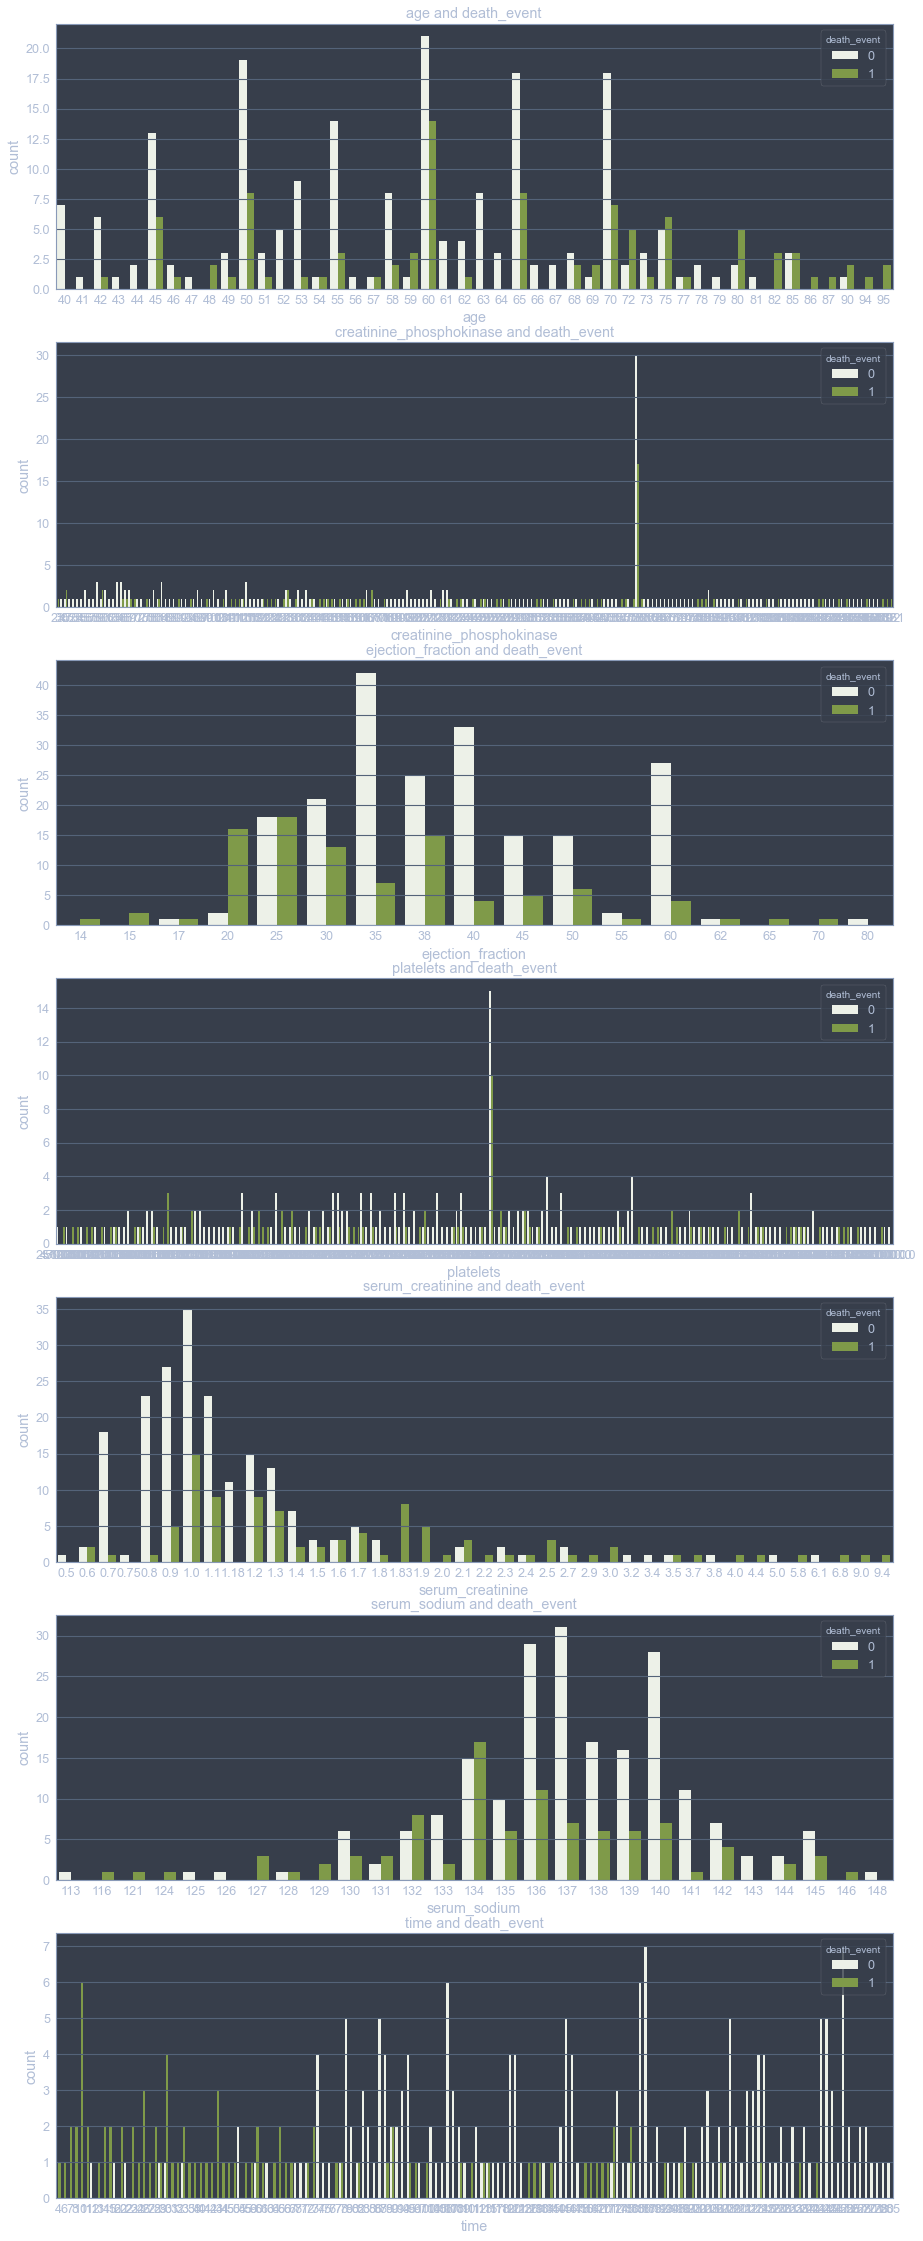

In [14]:
fig, ax = plt.subplots(nrows = 7,ncols = 1,figsize = (15,40))
for i in range(len(list_of_numerical_features)):
    plt.subplot(7,1,i+1)
    sns.countplot(x = data[list_of_numerical_features[i]],data=data, hue='death_event',color = 'g');
    title = list_of_numerical_features[i] + ' and death_event' 
    plt.title(title)

На графиках по оси х слишком много точек, поэтому их сложно итерпретировать, возможно,  в этих случаях более информативными будут другие виды графикв...

Но однозначно можно сказать, что мы наблюдаем увеличение смертности начиная с 42 лет. Пики смертности приходятся на вораст 45, 50,60 65, 70, 72 75 и 80 лет.
Повышается риск смертности при проценте крови, покидающей сердце при каждом сокращении, равном от 20 до 60. Пики приходятся на процент равный 20, 25, 30 и 38.
При уровене сывороточного креатинина в крови начиная с 0.6 до 3.0, мы видим рост смертности, ощутымый рост приходится на значения 0.9-1.1, 1.2 и 1.3, 1,83, 1.9.
Уровень сывороточного натрия начиная с 127 - 145 свидетельсьтвует о риске смертности.

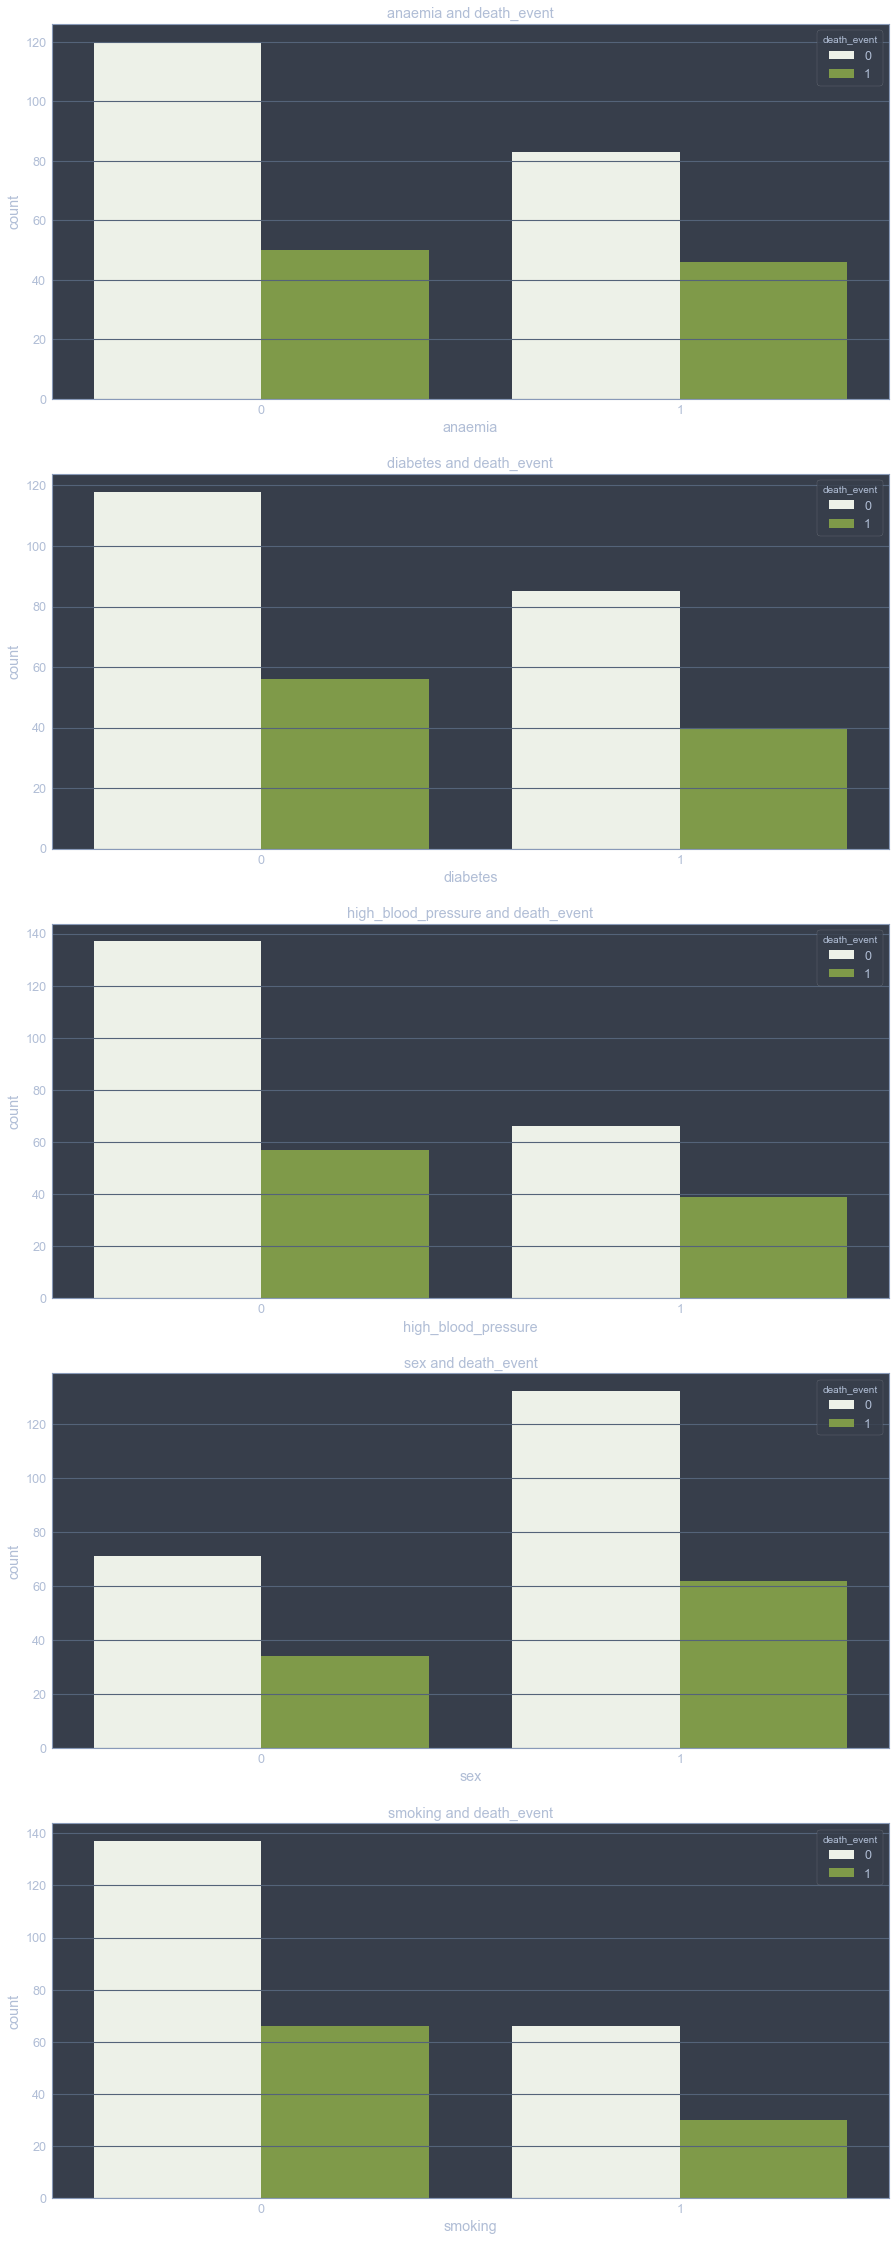

In [15]:
fig, ax = plt.subplots(nrows = 5,ncols = 1,figsize = (15,40))
for i in range(len(list_of_categorical_features)-1):
    plt.subplot(5,1,i+1)
    sns.countplot(x = data[list_of_categorical_features[i]],data=data, hue='death_event',color = 'g');
    title = list_of_categorical_features[i] + ' and death_event' 
    plt.title(title)

Согласно графикам наличие анемии не увеличивает риски смерти от серденой недостаточности, отсутствие диабета и высого давления, а так же факта курения несколько увеличивает риски смертности. Смертность от сердечной недостаточности среди мужчин на порядок выше чем среди женщин.

Итак, нужно подумать как визуализировать признаки time, platelets, creatinine_phosphokinase так, чтобы определить диапозон значений с высоким риском смертности...

##### Категоризация времени, разбиение на недели.

In [30]:
data['time_week'] = (data['time']-1)//7
data.sample(8)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event,time_week
20,65,1,52,0,25,1,276000.0,1.3,137,0,0,16,0,2
115,58,1,400,0,40,0,164000.0,1.0,139,0,0,91,0,12
151,62,0,30,1,60,1,244000.0,0.9,139,1,0,117,0,16
164,45,0,2442,1,30,0,334000.0,1.1,139,1,0,129,1,18
191,64,1,62,0,60,0,309000.0,1.5,135,0,0,174,0,24
198,50,1,582,1,20,1,279000.0,1.0,134,0,0,186,0,26
203,60,0,59,0,25,1,212000.0,3.5,136,1,1,187,0,26
263,68,1,157,1,60,0,208000.0,1.0,140,0,0,237,0,33


In [33]:
df_time = pd.DataFrame()

df_time['death'] = data.groupby('time_week')['death_event'].sum()
df_time['count'] = data.groupby('time_week')['death_event'].count()
df_time['percent_of_death'] = round(df_time['death']*100/df_time['count'], 0)

df_time.sort_values(by='percent_of_death', ascending=False)

,death,count,percent_of_death
time_week,,,
0,4,4,100.0
18,2,2,100.0
5,4,4,100.0
6,5,5,100.0
23,1,1,100.0
1,13,14,93.0
3,9,10,90.0
9,5,6,83.0
2,4,5,80.0


<AxesSubplot:xlabel='time_week', ylabel='percent_of_death'>

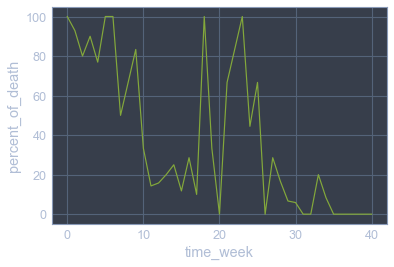

In [28]:
sns.lineplot(data=df_time, x="time_week", y="percent_of_death", color = 'g')

Вот так мы видим, что смертность выше 50% на промежутке наблюдения до 10 недель, между 21 и 24 неделями и на 18-й неделе.